In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import os

# Set the random seed for reproducible results
SEED = 6
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define transformations to include grayscale conversion
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Root directory for the dataset
root_dir = '~/Brain Tumor Data Set'

# Create the full dataset from both 'Healthy' and 'Brain Tumor' folders
full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Define the train and validation split (80/20)
train_size = int(0.8 * len(full_dataset))
validation_size = len(full_dataset) - train_size

# Split the dataset into training and validation datasets
train_set, val_set = random_split(full_dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(SEED))

# Create the DataLoaders for training and validation sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=0)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modifications for the fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 4


C:\Users\nici_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nici_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(train_set if phase == 'train' else val_set)
            epoch_acc = running_corrects.double() / len(train_set if phase == 'train' else val_set)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

# Start training
model_trained, history = train_model(model, criterion, optimizer, scheduler, num_epochs=4)

Epoch 1/4
----------
train Loss: 0.3813 Acc: 0.8171
val Loss: 0.2213 Acc: 0.9152
Epoch 2/4
----------
train Loss: 0.1466 Acc: 0.9484
val Loss: 0.1149 Acc: 0.9609
Epoch 3/4
----------
train Loss: 0.0914 Acc: 0.9679
val Loss: 0.1008 Acc: 0.9663
Epoch 4/4
----------
train Loss: 0.0489 Acc: 0.9840
val Loss: 0.0636 Acc: 0.9804


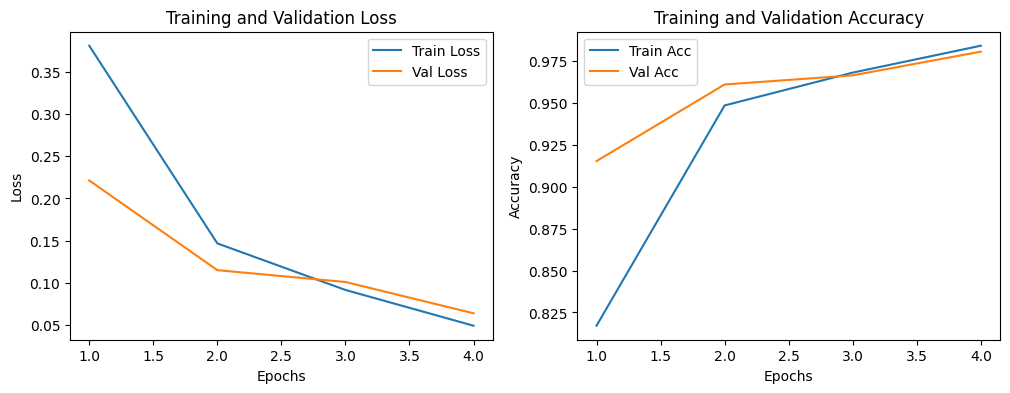

In [19]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 4))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), history['train_loss'], label='Train Loss')
plt.plot(range(1, num_epochs+1), history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), history['train_acc'], label='Train Acc')
plt.plot(range(1, num_epochs+1), history['val_acc'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
            
    return true_labels, predictions

true_labels, predictions = get_predictions(model_trained, val_loader)

Accuracy: 0.9870
Precision: 0.9837
Recall: 0.9883
F1 Score: 0.9860


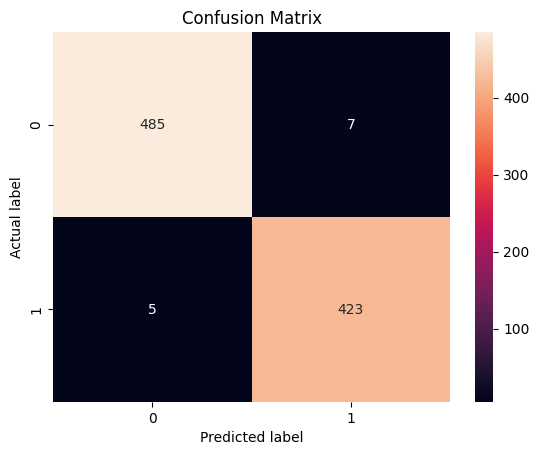

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='binary')
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
import torch.nn.functional as F

def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_true_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.view(-1).cpu().numpy())
            all_true_labels.extend(labels.view(-1).cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].view(-1).cpu().numpy())  # Assuming index 1 is the positive class
            
    return all_true_labels, all_predictions, all_probabilities

# Call the updated get_predictions function
true_labels, predictions, probabilities = get_predictions(model_trained, val_loader)

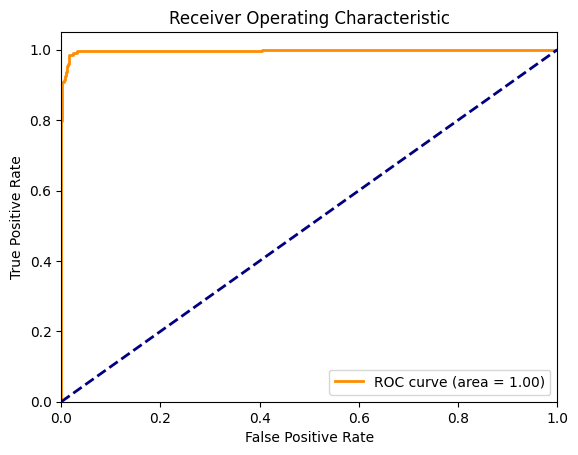

In [23]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

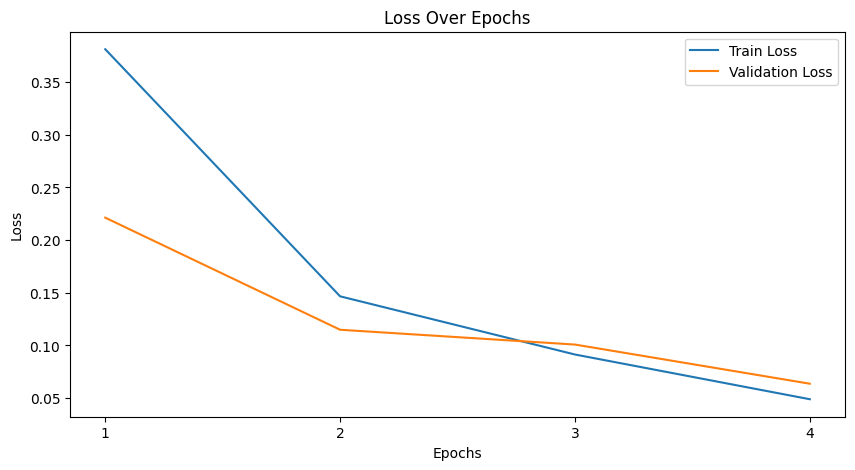

In [26]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), history['train_loss'], label='Train Loss')
plt.plot(range(1, num_epochs+1), history['val_loss'], label='Validation Loss')
plt.xticks(range(1, num_epochs+1))  # Ensure x-axis labels match the number of epochs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

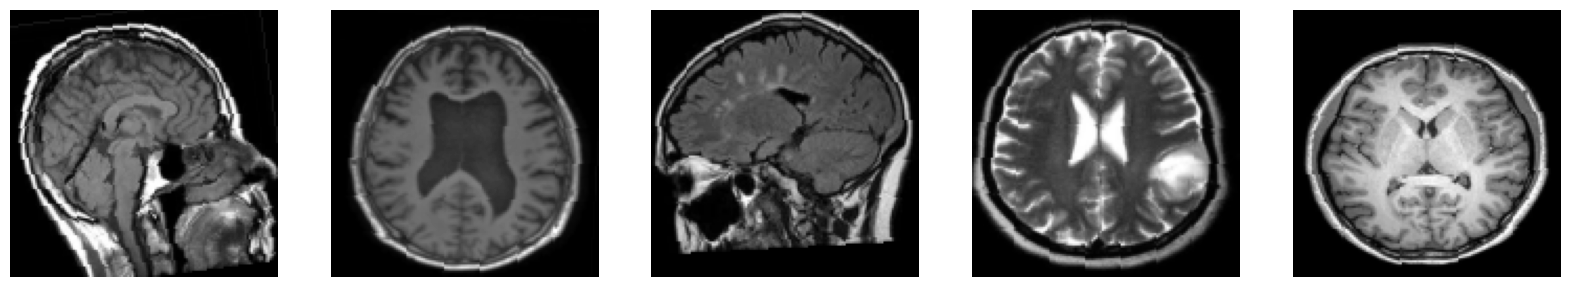

In [25]:
import matplotlib.pyplot as plt

def visualize_false_negatives(images, num_images=5):
    # Select the number of images to display
    images_to_display = images[:num_images]
    
    # Set up the figure size
    plt.figure(figsize=(20, 4))
    
    # Loop through the selected images
    for i, image in enumerate(images_to_display):
        # Convert tensor image to numpy array if it's not already
        if isinstance(image, torch.Tensor):
            image = image.numpy()
        
        # If the image has a channel dimension in the first position, move it to the last position
        if image.shape[0] in (1, 3):  # Grayscale or RGB
            image = image.transpose((1, 2, 0))
        
        # If the image is grayscale, remove the channel dimension
        if image.shape[-1] == 1:
            image = image.squeeze()
        
        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    
    # Show the plot
    plt.show()

# Example usage:
visualize_false_negatives(false_negative_images, num_images=5)